<a href="https://colab.research.google.com/github/mwizard1010/SIT_796/blob/main/3.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install required system dependencies
# install required system dependencies
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
  PyOpenGL==3.1.* \
  PyOpenGL-accelerate==3.1.* \
  gym[box2d]==0.17.* 
!pip install pyglet

zsh:1: command not found: apt-get
zsh:1: no matches found: PyVirtualDisplay==2.0.*


In [ ]:
# from google.colab import drive
# import sys
# drive.mount('/content/drive')
# sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')

import world
from world import World

In [ ]:
import gym
import numpy as np
import base64
import io
import IPython

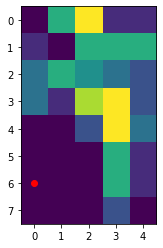

<Figure size 432x288 with 0 Axes>

In [ ]:
import random

#Map information
grid = [8, 5]
dirt = [[0, 0.5, 0.8, 0.1, 0.1],
        [0.1, 0, 0.5, 0.5, 0.5],
        [0.3, 0.5, 0.4, 0.3, 0.2],
        [0.3, 0.1, 0.7, 0.8, 0.2],
        [0, 0, 0.2, 0.8, 0.3],
        [0, 0, 0, 0.5, 0.1],
        [0, 0, 0, 0.5, 0.1],
        [0, 0, 0, 0.2, 0]]
moves = 1000
pos = [6, 0]

# Random setting
seed = 1  
random.seed(seed)


#Env load
env = World(pos, moves, grid, dirt)
obs = env.reset()
env.render()

In [ ]:
def get_action_value(env, state_values, position, action, gamma):
    env.reset()
    env.position = position
    actions = env._action_space()
    obs, r, d, info  = env.step(actions[action])
    new_position = env.position
    return r + gamma * state_values[new_position[0], new_position[1]]

In [ ]:
def init_policy(env):
    policy = np.zeros((env.grid_size[0], env.grid_size[1], len(env._action_space())))
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            actions = env._action_space()
            for i_action in range(len(actions)):
                policy[i][j][i_action] = 0
    return policy

def best_action(policy, i , j): 
    actions = policy[i][j]
    sort_l = np.sort(actions)
    first, = np.where(actions == sort_l[-1])
    second, = np.where(actions == sort_l[-2])
    return first[0], second[0]

In [ ]:
def policy_eval(env, policy, gamma, theta=0.00001):
    num_iter = 100  # maximum iterations, excluding initialization
    # initialize V(s)
    V = np.zeros((env.grid_size[0], env.grid_size[1]))
    for i in range(num_iter):
        delta = 0
        # Compute new state values using the functions defined above.
        new_V = V.copy()
        for i in range(env.grid_size[0]):
            for j in range(env.grid_size[1]):

                action_policy,_ = best_action(policy, i ,j)
                new_V[i, j] = get_action_value(env, V, [i, j], action_policy, gamma)
        delta = max(delta, abs(new_V[i, j] - V[i, j]))         
        V = new_V
        if delta < theta:
            break
    return V

In [ ]:
def policy_improvement(env, policy_eval_fn=policy_eval, gamma=0.9):
    num_iter = 100  # maximum iterations, excluding initialization
    policy = init_policy(env)
    for t in range(num_iter):
      V = policy_eval_fn(env, policy, gamma)
      # Will be set to false if we make any changes to the policy
      policy_stable = True
      # For each state...
      for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
          # The best action we would take under the current policy
          chosen_a,_ = best_action(policy, i ,j)

          actions = env._action_space()
          A = np.zeros(len(actions))
          for action_i, action in enumerate(actions):
              v = get_action_value(env, V, [i, j], action_i, gamma)
              A[action_i] = v

          sort_l = np.sort(A)
          first, = np.where(A == sort_l[-1])
          second, = np.where(A == sort_l[-2])

          #best_a = np.argmax(A)

          # Update the policy
          if chosen_a != first[0]:
              policy_stable = False
          for action_i in range(len(actions)):
            if action_i == first[0]:
              policy[i][j][action_i] = 0.7
            elif action_i == second[0]:
              policy[i][j][action_i] = 0.3
            else:
              policy[i][j][action_i] = 0
      # If the policy is stable we've found an optimal policy. Return it
      if policy_stable:
          return policy, V
      print("iter %4i " % (t + 1))
    return policy, V

In [ ]:
import pprint
env.reset()
policy, v = policy_improvement(env)

iter    1 
iter    2 
iter    3 
iter    4 
iter    5 
iter    6 


In [ ]:
def opt_policy(env, policy):
    policy_max = np.max(policy, axis=2)
    # print(policy_max)
    y = np.linspace(env.grid_size[0] - 1, 0, env.grid_size[0]) + 0.5
    x = np.linspace(0, env.grid_size[1] - 1, env.grid_size[1]) + 0.5
    X, Y = np.meshgrid(x, y)
    zeros = np.zeros((env.grid_size))
    
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes()
    
    for i_action, action in enumerate(env._action_space()):
        policy_star = np.zeros((env.grid_size[0], env.grid_size[1]))
        for i in reversed(range(env.grid_size[0])):
            for j in reversed(range(env.grid_size[1])):
                # if policy[i, j, i_action] == policy_max[i, j]:
                if policy[i, j, i_action] != 0:
                    policy_star[i, j] = 0.4

        #Plot results
        if action == "U":
            # Vectors point in positive Y-direction
            plt.quiver(X, Y, zeros, policy_star, scale=1, units='xy')
        elif action == "L":
            # Vectors point in negative X-direction
            plt.quiver(X, Y, -policy_star, zeros, scale=1, units='xy')
        elif action == "D":
            # Vectors point in negative Y-direction
            plt.quiver(X, Y, zeros, -policy_star, scale=1, units='xy')
        elif action == "R":
            # Vectors point in positive X-direction
            plt.quiver(X, Y, policy_star, zeros, scale=1, units='xy')
        
    plt.xlim([0, env.grid_size[1]])
    plt.ylim([0, env.grid_size[0]])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.grid()
    plt.show()

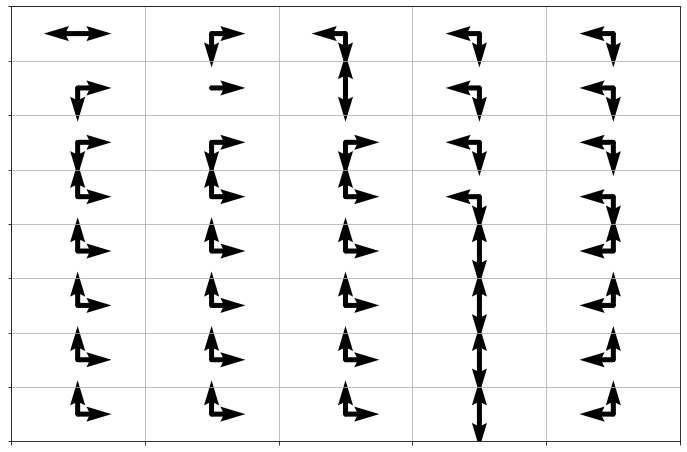

In [ ]:
import matplotlib.pyplot as plt
opt_policy(env, policy)

In [ ]:

#initital parametters
reward = []
for _ in range(1000):
    position = env.position
    first, second = best_action(policy, position[0], position[1])
    action = first
    if np.random.uniform(0,1) < 0.3:
      action = second
    actions = env._action_space()
    obs, r, d, info  = env.step(actions[action])    
    reward.append(r)
    # env.render()
    if d:
        env.reset()

In [ ]:
print("average reward: ", np.mean(reward))

average reward:  0.0036999999999999997


In [ ]:
from _mdp import MDP
transition_probs = {}
rewards = {}
actions = env._action_space()
for i in range(env.grid_size[0]):
    for j in range(env.grid_size[1]):
        action_space = {}
        action_reward = {}
        for action_i, action in enumerate(actions):
            env.reset()
            env.position = [i, j]
            obs, r, d, info  = env.step(action)
            new_position = env.position
            newstate = '{}_{}'.format(new_position[0], new_position[1])
            action_space[action] = {newstate : 1}
            if (r > 0):
                action_reward[action] = {newstate : r}
        state = '{}_{}'.format(i,j)
        transition_probs[state] = action_space
        if(len(action_reward) > 0):
            rewards[state] = action_reward

pos = [6, 0]
model = MDP(transition_probs, rewards, initial_state='6_0')

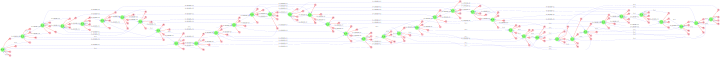

In [ ]:
from _mdp import has_graphviz
from IPython.display import display
from _mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
img = plot_graph(model)
display(img)

In [ ]:
img.render(r'graph')

'graph.pdf'